<a href="https://colab.research.google.com/github/Snrts/PRA3024_BigDataInPhysics_SanneAarts/blob/Week2/PRA3024W2ParticlePhysics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:

# %pip install uproot awkward lz4 xxhash
# !pip install numpy==1.19.5
# %pip install numba==0.54
# %pip install matplotlib
# %pip install pandas
# %pip install zfit
# %pip install zfit-physics
# %pip install zfit
# %pip install minuit
# %pip install probfit
# %pip install iminuit numpy==1.19.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 11.6 MB/s eta 0:00:00
  Attempting uninstall: iminuit
    Found existing installation: iminuit 2.20.0
    Uninstalling iminuit-2.20.0:
      Successfully uninstalled iminuit-2.20.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
zfit 0.11.1 requires iminuit>=2.3, but you have iminuit 1.5.4 which is incompatible.


In [138]:
import zfit
import zfit.z.numpy as znp
# import zfit_physics as zphysics  
from zfit import z
import scipy
from scipy.stats import crystalball, expon, norm
from scipy.optimize import curve_fit, minimize
import matplotlib.pyplot as plt
import numpy as np
import uproot
import iminuit
from iminuit import Minuit,cost
import pandas as pd
import probfit
from probfit.plotting import draw_normed_pdf
from probfit import gaussian, UnbinnedLH, BinnedLH

In [15]:
# from google.colab import drive
# drive.mount('/content/drive')

In [16]:
f = uproot.open("/content/drive/MyDrive/B2HHH_MagnetUp.root:DecayTree")
f.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
B_FlightDistance     | double                   | AsDtype('>f8')
B_VertexChi2         | double                   | AsDtype('>f8')
H1_PX                | double                   | AsDtype('>f8')
H1_PY                | double                   | AsDtype('>f8')
H1_PZ                | double                   | AsDtype('>f8')
H1_ProbK             | double                   | AsDtype('>f8')
H1_ProbPi            | double                   | AsDtype('>f8')
H1_Charge            | int32_t                  | AsDtype('>i4')
H1_IPChi2            | double                   | AsDtype('>f8')
H1_isMuon            | int32_t                  | AsDtype('>i4')
H2_PX                | double                   | AsDtype('>f8')
H2_PY                | double                   | AsDtype('>f8')
H2_PZ                | double                   | AsDtype(

# Total momentum of Daughters
$$P_{tot}=\sqrt{P_x^2+P_y^2+P^2_z}$$

In [17]:
# f.arrays creates an array containing 
H1Ptot = f.arrays("sqrt(H1_PX**2+H1_PY**2+H1_PZ**2)", library="np")["sqrt(H1_PX**2+H1_PY**2+H1_PZ**2)"]
H2Ptot = f.arrays("sqrt(H2_PX**2+H2_PY**2+H2_PZ**2)", library="np")['sqrt(H2_PX**2+H2_PY**2+H2_PZ**2)']
H3Ptot = f.arrays("sqrt(H3_PX**2+H3_PY**2+H3_PZ**2)", library="np")['sqrt(H3_PX**2+H3_PY**2+H3_PZ**2)']

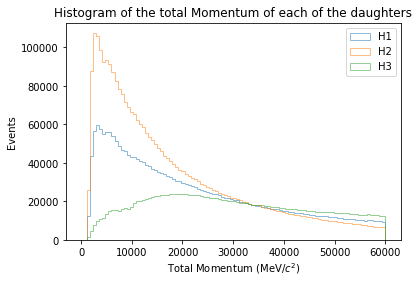

In [18]:
plt.hist(H1Ptot, bins= 100, alpha=0.5, range=[0, 60000], histtype = 'step', label="H1")
plt.hist(H2Ptot, bins= 100, alpha=0.5, range=[0, 60000], histtype = 'step', label="H2")
plt.hist(H3Ptot, bins= 100, alpha=0.5, range=[0, 60000], histtype = 'step',  label="H3")
plt.xlabel("Total Momentum (MeV/$c^2$)")
plt.ylabel("Events")
plt.title("Histogram of the total Momentum of each of the daughters")
plt.legend(loc='upper right')
plt.show()

# Total momentum of mother
$$M_{Ptot}=\sqrt{(H1_{PX}+H2_{PX}+H3_{PX})^2+(H1_{PY}+H2_{PY}+H3_{PY})^2+(H1_{PZ}+H2_{PZ}+H3_{PZ})^2}$$

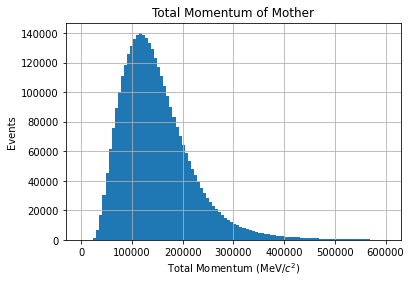

In [19]:
def momentumtot(component):#function which uses fstrings to find the sum of the momenta of the daughters in the specified direction
    return f.arrays(f"H1_P{component}+H2_P{component}+H3_P{component}", library="np")[f"H1_P{component}+H2_P{component}+H3_P{component}"]

momentumMother = np.sqrt(momentumtot("X")**2+momentumtot("Y")**2+momentumtot("Z")**2)#uses said function to find the momentum of the mother
 
plt.hist(momentumMother, bins= 100, range=[0, 600000])
plt.xlabel("Total Momentum (MeV/$c^2$)")
plt.ylabel("Events")
plt.title("Total Momentum of Mother")
plt.grid()
plt.show()

$$E_{children}^2-p_{children}^2=m_{mother}^2$$ 
$$E_{children}=E_1+E_2+E_3=\sqrt{p^2_1+m_1^2}+\sqrt{p^2_2+m_2^2}+\sqrt{p^2_3+m_3^2}$$

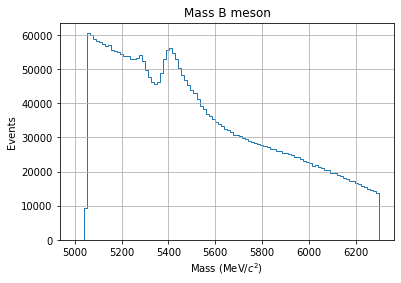

In [20]:
def energy(momentum):
    mass = 493.677 # mass of Kaon in MeV/c^2
    return np.sqrt(momentum**2+mass**2)

daughtersEnergy = energy(H1Ptot)+energy(H2Ptot)+energy(H3Ptot)

motherMass = np.sqrt(daughtersEnergy**2-momentumMother**2)

plt.hist(motherMass, bins= 100, histtype="step", range=[5000,6300])
plt.xlabel("Mass (MeV/$c^2$)")
plt.ylabel("Events")
plt.title("Mass B meson")
plt.grid()
plt.show()

In [21]:
def probability(number, type):
    return f.arrays(f"H{number}_Prob{type}",library="np")[f'H{number}_Prob{type}']

def makeplots(type):
    plt.hist(probability(1, type), bins= 100, range=[0, 1], label="H1", histtype = 'step')
    plt.hist(probability(2, type), bins= 100, range=[0, 1], label="H2", histtype = 'step')
    plt.hist(probability(3, type), bins= 100, range=[0, 1], label="H3", histtype = 'step')
    plt.title(f"Probability of H1, H2 or H3 being a {type}")
    plt.ylabel("Events")
    plt.xlabel("Probability")
    plt.grid()
    plt.legend(loc="best")
    plt.show()


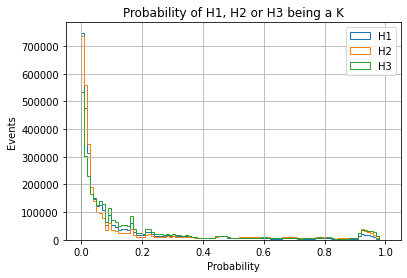

In [22]:
makeplots("K")

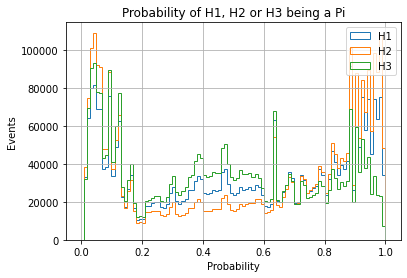

In [23]:
makeplots("Pi")

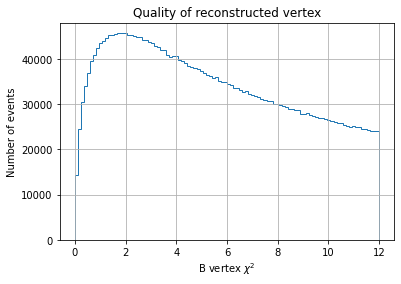

In [24]:
chi = f.arrays("B_VertexChi2", library="np")["B_VertexChi2"]
plt.hist(chi, bins=100, histtype="step")
plt.grid()
plt.xlabel("B vertex $\chi^2$")
plt.ylabel("Number of events")
plt.title("Quality of reconstructed vertex")
plt.show()

In [25]:
def filter(n):
    return f"(H{n}_ProbK>0.7)&(H{n}_isMuon==0)"

filt = f"{filter(1)}&{filter(2)}&{filter(3)}"
cut = f.arrays(cut=filt,library="np")


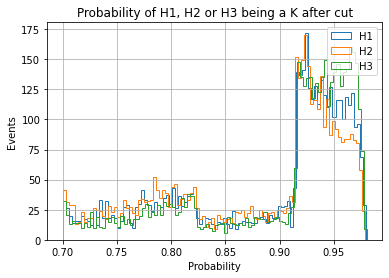

In [26]:
plt.hist(cut["H1_ProbK"], bins= 100,  label="H1", histtype = 'step')
plt.hist(cut["H2_ProbK"], bins= 100,  label="H2", histtype = 'step')
plt.hist(cut["H3_ProbK"], bins= 100,  label="H3", histtype = 'step')
plt.title(f"Probability of H1, H2 or H3 being a K after cut")
plt.ylabel("Events")
plt.xlabel("Probability")
plt.grid()
plt.legend(loc="best")
plt.show()

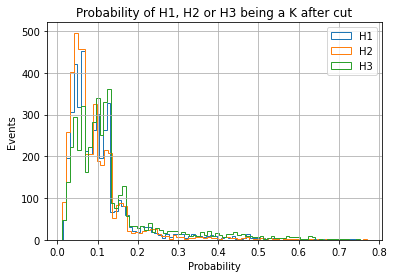

In [27]:
plt.hist(cut["H1_ProbPi"], bins= 80,  label="H1", histtype = 'step')
plt.hist(cut["H2_ProbPi"], bins= 80,  label="H2", histtype = 'step')
plt.hist(cut["H3_ProbPi"], bins= 80,  label="H3", histtype = 'step')
plt.title(f"Probability of H1, H2 or H3 being a K after cut")
plt.ylabel("Events")
plt.xlabel("Probability")
plt.grid()
plt.legend(loc="best")
plt.show()

In [75]:
def childMomentumCut(n):
    return np.sqrt(cut[f"H{n}_PX"]**2+cut[f"H{n}_PY"]**2+cut[f"H{n}_PZ"]**2)

def motherMomentumComponentCut(direction):
    return cut[f"H1_P{direction}"]+cut[f"H2_P{direction}"]+cut[f"H3_P{direction}"]

daughtersEnergyCut = energy(childMomentumCut(1))+energy(childMomentumCut(2))+energy(childMomentumCut(3))
motherMomentumCut = np.sqrt(motherMomentumComponentCut("X")**2+motherMomentumComponentCut("Y")**2+motherMomentumComponentCut("Z")**2)

motherMassCut = np.sqrt(daughtersEnergyCut**2-motherMomentumCut**2)
motherMassCut = np.array([m for m in motherMassCut if (m>5100) and (m<5500)])


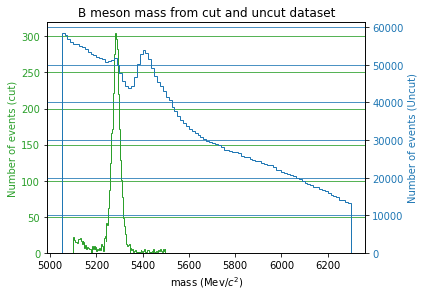

In [29]:
fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('mass (Mev/$c^2$)')
ax1.set_ylabel('Number of events (cut)', color=color)
ax1.hist(motherMassCut, bins=100, color=color, histtype="step", label="cut")
ax1.tick_params(axis='y', labelcolor=color)
plt.grid(axis='y', color=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of events (Uncut)', color=color)
ax2.hist(motherMass, bins=100, color=color, histtype="step", label="uncut")
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.grid(axis='y', color=color, which='both')
plt.grid(axis='x', color='g')
plt.title("B meson mass from cut and uncut dataset")
plt.show()

## Fitting the Data

In [177]:
m_data=np.linspace(np.max(motherMassCut),np.min(motherMassCut),len(motherMassCut))
# p0=[np.mean(motherMassCut),np.std(motherMassCut),2,3,1]
# p0=dict(mu=np.mean(motherMassCut),sigma=np.std(motherMassCut), alph=2, n=3, tau=1)

def gaussian(x,mu,sigma):
    return probfit.pdf.gaussian(x, mu, sigma)
def crystalBall(x,alph,n, mu, sigma):
    return probfit.pdf.crystalball(x,alph,n, mu, sigma)

def exponential(x,tau):
    return np.exp(-tau*x)

# gaussian(m_data,p0["mu"],p0["sigma"]);
p0=dict(mu=np.mean(motherMassCut),sigma=np.std(motherMassCut), alph=2, n=3, tau=1)

In [100]:
# def plotter(models, mu,sigma):
#     # list=models
#     # for i in list:
#     plt.plot(m_data,globals()[models](m_data,mu,sigma),linestyle='--',linewidth=2, label=models)
#     plt.hist(motherMassCut,alpha=0.25,bins=100, density=True, label="Data", color="k")
#     plt.xlabel("Invariant mass of the B-meson $MeV/c^2$")
#     plt.ylabel("Number of events (Normalized)")
#     plt.legend()
#     plt.grid()
#     plt.show()

# plotter("gaussian",p0["mu"],p0["sigma"])


In [230]:
def checking(model, params):
    binned_likelihood=probfit.costfunc.BinnedLH(model, motherMassCut)
    minuit=iminuit.Minuit(binned_likelihood, **params)
    print("Results are valid:" , minuit.valid)
    print("Results are accurate:", minuit.accurate)
    print(minuit.fmin)
    # print(minuit.matrix) 
    pminuit.
    return minuit.migrad()
   

Results are valid: False
Results are accurate: False
None


ValueError: ignored

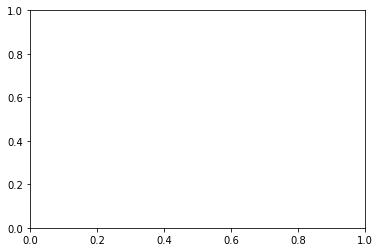

In [232]:
checking(gaussian, dict(mu=np.mean(motherMassCut), sigma=np.std(motherMassCut)))

In [ ]:
checking(crystalBall, dict(mu=np.mean(motherMassCut), sigma=np.std(motherMassCut),alph=3, n=1.5) )

In [202]:
checking(exponential, dict(tau=-4) )

Results are valid: False
Results are accurate: False


AttributeError: ignored

In [ ]:
def childrenCharge():
    return "H1_Charge+H2_Charge+H3_Charge"

# condition = f"{filter(1)}&{filter(2)}&{filter(3)}"
# cut = f.arrays(cut=condition,library="np")    
Nminus = len(f.arrays(cut=f"({childrenCharge()}==-1)&{condition}", library="pd"))
Nplus = len(f.arrays(cut=f"({childrenCharge()}==1)&{condition}", library="pd"))
print(Nplus)
print(Nminus)

def asymmetry(Nplus, Nminus):
    return (Nminus-Nplus)/(Nminus+Nplus)

def deviation(Nplus, Nminus):
    return np.sqrt((1-asymmetry(Nplus, Nminus)**2)/(Nminus+Nplus))

print("The deviation is:", deviation(Nminus,Nplus))
print("The Asymmetry is:", asymmetry(Nminus,Nplus))